In [3]:
!pip install scipy==1.1.0

  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


ERROR: tensorflow 2.1.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: hyperopt 0.2.2 has requirement networkx==2.2, but you'll have networkx 2.4 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'd:\\anaconda\\lib\\site-packages\\~cipy\\fft\\_pocketfft\\pypocketfft.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
import torchvision

In [10]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import PIL
import torchvision.transforms as T
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data import sampler
import torchvision.datasets as dset
from scipy.misc import imresize

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

root = r'D:\2nd_semester\bigdatascience\project\10_video'
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
#1920 * 1080

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 1920

# Size of feature maps in generator
ngf = 1080

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [11]:
# Create the dataloader
dataset = dset.ImageFolder(root= r'D:\2nd_semester\bigdatascience\project\10_video',
                           transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
#transforms = transforms.Compose([transforms.ToTensor()])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# Plot some training images
#real_batch = next(iter(dataloader))
#plt.figure(figsize=(8,8))
#plt.axis("off")
#plt.title("Training Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [14]:
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

RuntimeError: CUDA out of memory. Tried to allocate 1014.00 MiB (GPU 0; 4.00 GiB total capacity; 0 bytes already allocated; 3.06 GiB free; 0 bytes cached)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [16]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [17]:
#### Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        #print(real_cpu)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        #print(netD(real_cpu))
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            

        iters += 1

Starting Training Loop...
[0/500][0/9]	Loss_D: 1.8024	Loss_G: 5.9803	D(x): 0.5991	D(G(z)): 0.6197 / 0.0040
[1/500][0/9]	Loss_D: 0.4847	Loss_G: 8.8396	D(x): 0.9309	D(G(z)): 0.2909 / 0.0003
[2/500][0/9]	Loss_D: 0.3069	Loss_G: 15.7625	D(x): 0.8194	D(G(z)): 0.0001 / 0.0000
[3/500][0/9]	Loss_D: 0.2402	Loss_G: 11.7329	D(x): 0.8148	D(G(z)): 0.0002 / 0.0000
[4/500][0/9]	Loss_D: 0.0941	Loss_G: 14.8997	D(x): 0.9444	D(G(z)): 0.0000 / 0.0000
[5/500][0/9]	Loss_D: 0.8235	Loss_G: 13.6058	D(x): 0.7194	D(G(z)): 0.0000 / 0.0000
[6/500][0/9]	Loss_D: 0.8751	Loss_G: 15.2703	D(x): 0.9732	D(G(z)): 0.5077 / 0.0000
[7/500][0/9]	Loss_D: 0.3571	Loss_G: 9.6756	D(x): 0.9451	D(G(z)): 0.2030 / 0.0002
[8/500][0/9]	Loss_D: 0.5530	Loss_G: 14.0276	D(x): 0.9734	D(G(z)): 0.3738 / 0.0000
[9/500][0/9]	Loss_D: 0.1199	Loss_G: 16.3913	D(x): 0.9043	D(G(z)): 0.0000 / 0.0000
[10/500][0/9]	Loss_D: 0.0632	Loss_G: 7.3967	D(x): 0.9474	D(G(z)): 0.0005 / 0.0009
[11/500][0/9]	Loss_D: 0.0934	Loss_G: 8.0073	D(x): 0.9321	D(G(z)): 0.0102 / 

[100/500][0/9]	Loss_D: 3.0736	Loss_G: 5.3443	D(x): 0.9858	D(G(z)): 0.8892 / 0.0343
[101/500][0/9]	Loss_D: 1.5041	Loss_G: 4.5193	D(x): 0.7330	D(G(z)): 0.4463 / 0.0626
[102/500][0/9]	Loss_D: 1.0159	Loss_G: 4.9386	D(x): 0.9464	D(G(z)): 0.5083 / 0.0257
[103/500][0/9]	Loss_D: 0.7859	Loss_G: 4.0237	D(x): 0.6502	D(G(z)): 0.1180 / 0.0625
[104/500][0/9]	Loss_D: 0.7685	Loss_G: 3.8220	D(x): 0.6756	D(G(z)): 0.1379 / 0.0639
[105/500][0/9]	Loss_D: 0.6597	Loss_G: 3.6640	D(x): 0.9586	D(G(z)): 0.4008 / 0.0546
[106/500][0/9]	Loss_D: 0.4299	Loss_G: 2.5066	D(x): 0.7307	D(G(z)): 0.0530 / 0.1466
[107/500][0/9]	Loss_D: 1.6319	Loss_G: 5.7343	D(x): 0.9678	D(G(z)): 0.6381 / 0.0172
[108/500][0/9]	Loss_D: 0.4552	Loss_G: 3.0898	D(x): 0.8665	D(G(z)): 0.2379 / 0.0719
[109/500][0/9]	Loss_D: 1.6499	Loss_G: 5.5433	D(x): 0.9819	D(G(z)): 0.7275 / 0.0204
[110/500][0/9]	Loss_D: 1.0681	Loss_G: 4.6335	D(x): 0.9641	D(G(z)): 0.5218 / 0.0464
[111/500][0/9]	Loss_D: 1.6971	Loss_G: 4.9140	D(x): 0.6583	D(G(z)): 0.3431 / 0.0397
[112

[199/500][0/9]	Loss_D: 0.3027	Loss_G: 5.3742	D(x): 0.9725	D(G(z)): 0.2099 / 0.0133
[200/500][0/9]	Loss_D: 0.4449	Loss_G: 5.0619	D(x): 0.9396	D(G(z)): 0.2517 / 0.0239
[201/500][0/9]	Loss_D: 0.1368	Loss_G: 3.7824	D(x): 0.9193	D(G(z)): 0.0448 / 0.0369
[202/500][0/9]	Loss_D: 0.1828	Loss_G: 4.1871	D(x): 0.8597	D(G(z)): 0.0156 / 0.0350
[203/500][0/9]	Loss_D: 0.1096	Loss_G: 3.7627	D(x): 0.9426	D(G(z)): 0.0456 / 0.0401
[204/500][0/9]	Loss_D: 0.1227	Loss_G: 3.6943	D(x): 0.9623	D(G(z)): 0.0711 / 0.0482
[205/500][0/9]	Loss_D: 1.9725	Loss_G: 8.2936	D(x): 0.9061	D(G(z)): 0.6270 / 0.0085
[206/500][0/9]	Loss_D: 0.3226	Loss_G: 4.2327	D(x): 0.8140	D(G(z)): 0.0607 / 0.0430
[207/500][0/9]	Loss_D: 0.2392	Loss_G: 4.8677	D(x): 0.8622	D(G(z)): 0.0472 / 0.0228
[208/500][0/9]	Loss_D: 0.7543	Loss_G: 3.5945	D(x): 0.5876	D(G(z)): 0.0049 / 0.0571
[209/500][0/9]	Loss_D: 0.2250	Loss_G: 4.0848	D(x): 0.9554	D(G(z)): 0.1425 / 0.0291
[210/500][0/9]	Loss_D: 0.1642	Loss_G: 3.4250	D(x): 0.9137	D(G(z)): 0.0641 / 0.0583
[211

[298/500][0/9]	Loss_D: 0.8237	Loss_G: 2.7838	D(x): 0.7347	D(G(z)): 0.2106 / 0.2862
[299/500][0/9]	Loss_D: 0.1119	Loss_G: 4.3820	D(x): 0.9608	D(G(z)): 0.0635 / 0.0289
[300/500][0/9]	Loss_D: 0.3817	Loss_G: 5.0905	D(x): 0.9601	D(G(z)): 0.2316 / 0.0182
[301/500][0/9]	Loss_D: 0.1604	Loss_G: 4.6675	D(x): 0.9720	D(G(z)): 0.1103 / 0.0195
[302/500][0/9]	Loss_D: 2.8650	Loss_G: 6.4198	D(x): 0.8052	D(G(z)): 0.6685 / 0.0084
[303/500][0/9]	Loss_D: 0.7005	Loss_G: 5.5120	D(x): 0.9139	D(G(z)): 0.2498 / 0.0233
[304/500][0/9]	Loss_D: 0.1599	Loss_G: 4.7288	D(x): 0.9154	D(G(z)): 0.0512 / 0.0235
[305/500][0/9]	Loss_D: 0.3556	Loss_G: 4.7695	D(x): 0.9880	D(G(z)): 0.2421 / 0.0198
[306/500][0/9]	Loss_D: 0.6181	Loss_G: 4.4198	D(x): 0.9527	D(G(z)): 0.2954 / 0.0327
[307/500][0/9]	Loss_D: 0.1479	Loss_G: 4.3931	D(x): 0.9686	D(G(z)): 0.0899 / 0.0237
[308/500][0/9]	Loss_D: 0.1282	Loss_G: 3.9864	D(x): 0.9411	D(G(z)): 0.0565 / 0.0376
[309/500][0/9]	Loss_D: 0.1138	Loss_G: 4.3045	D(x): 0.9910	D(G(z)): 0.0935 / 0.0220
[310

[397/500][0/9]	Loss_D: 1.1462	Loss_G: 10.8624	D(x): 0.9974	D(G(z)): 0.5089 / 0.0005
[398/500][0/9]	Loss_D: 0.1048	Loss_G: 4.4661	D(x): 0.9878	D(G(z)): 0.0810 / 0.0220
[399/500][0/9]	Loss_D: 0.0507	Loss_G: 4.9107	D(x): 0.9787	D(G(z)): 0.0270 / 0.0141
[400/500][0/9]	Loss_D: 0.0819	Loss_G: 4.2425	D(x): 0.9752	D(G(z)): 0.0505 / 0.0280
[401/500][0/9]	Loss_D: 0.0718	Loss_G: 4.3948	D(x): 0.9874	D(G(z)): 0.0541 / 0.0208
[402/500][0/9]	Loss_D: 0.0504	Loss_G: 4.6950	D(x): 0.9726	D(G(z)): 0.0214 / 0.0166
[403/500][0/9]	Loss_D: 0.0394	Loss_G: 4.7667	D(x): 0.9851	D(G(z)): 0.0233 / 0.0160
[404/500][0/9]	Loss_D: 0.0495	Loss_G: 4.6723	D(x): 0.9714	D(G(z)): 0.0194 / 0.0170
[405/500][0/9]	Loss_D: 0.0554	Loss_G: 4.3027	D(x): 0.9789	D(G(z)): 0.0322 / 0.0282
[406/500][0/9]	Loss_D: 0.0522	Loss_G: 4.8031	D(x): 0.9610	D(G(z)): 0.0113 / 0.0147
[407/500][0/9]	Loss_D: 0.0556	Loss_G: 4.2854	D(x): 0.9741	D(G(z)): 0.0278 / 0.0257
[408/500][0/9]	Loss_D: 0.0346	Loss_G: 5.1677	D(x): 0.9818	D(G(z)): 0.0155 / 0.0117
[40

[496/500][0/9]	Loss_D: 0.0650	Loss_G: 4.3946	D(x): 0.9805	D(G(z)): 0.0420 / 0.0240
[497/500][0/9]	Loss_D: 0.3631	Loss_G: 5.7022	D(x): 0.9926	D(G(z)): 0.2526 / 0.0131
[498/500][0/9]	Loss_D: 0.0637	Loss_G: 4.9590	D(x): 0.9678	D(G(z)): 0.0286 / 0.0185
[499/500][0/9]	Loss_D: 0.0994	Loss_G: 4.5310	D(x): 0.9848	D(G(z)): 0.0721 / 0.0230


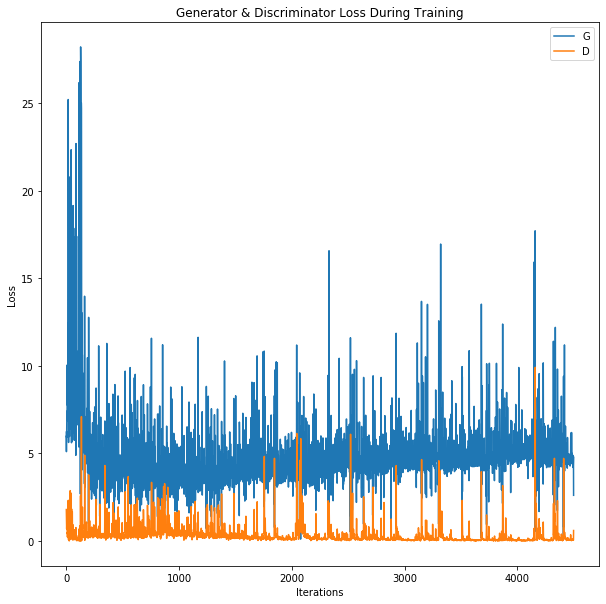

In [18]:
plt.figure(figsize=(10,10))
plt.title("Generator & Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label=
         "D")
plt.xlabel("Iterations")

plt.ylabel("Loss")
plt.legend()
plt.show()

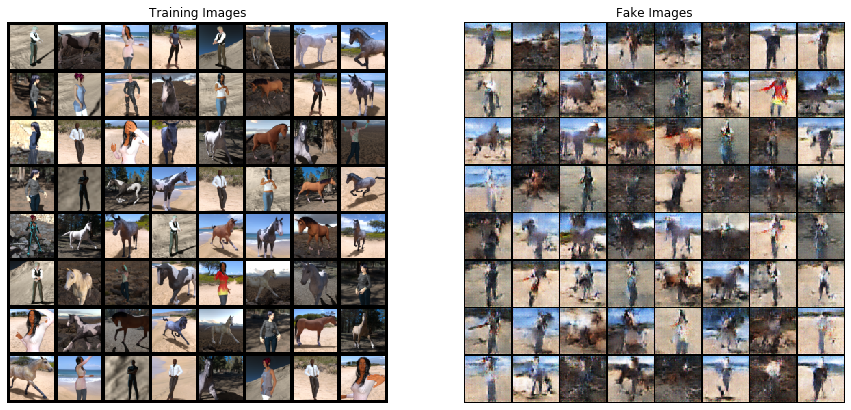

In [19]:
# Grab a batch of real images from the dataloader

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()